# Ładowanie danych

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split

TRAIN_DATA_FILE_PATH = "data/artificial_train.data"
TRAIN_LABELS_FILE_PATH = "data/artificial_train.labels"
VALID_DATA_FILE_PATH = "data/artificial_valid.data"

x_df = pd.read_csv(TRAIN_DATA_FILE_PATH,
                   header=None,
                   sep=" ",
                   usecols=range(500))
y_df = pd.read_csv(TRAIN_LABELS_FILE_PATH, header=None)
x_df_val = pd.read_csv(VALID_DATA_FILE_PATH,
                       header=None,
                       sep=" ",
                       usecols=range(500))

# Definy

In [2]:
def standarize(df):
    return (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))


def boruta_feature_selection(x, y):
    rfc = RandomForestClassifier(n_estimators=200,
                                 n_jobs=-1,
                                 class_weight='balanced',
                                 max_depth=7,
                                 random_state=0)
    boruta_selector = BorutaPy(rfc,
                               n_estimators='auto',
                               verbose=1,
                               random_state=0)
    boruta_selector.fit(x, y)
    features = np.where(boruta_selector.support_ +
                        boruta_selector.support_weak_ == True)[0]
    print(f"\rBoruta\nNumber of Selected Features: {features.shape[0]}")
    print("Selected Features: ")
    print(*features.tolist())
    return features.tolist()


def calculate_r_2_for_feature(data, feature, regression_type):
    new_data = data.drop(feature, axis=1)

    X_train, \
    X_test,  \
    y_train, \
    y_test = train_test_split(
        new_data,data[feature],test_size=0.25
    )
    if regression_type == "KNR":
        regressor = KNeighborsRegressor()
    elif regression_type == "DTR":
        regressor = DecisionTreeRegressor()
    else:
        raise Exception("Wrong type of regression, use:\n",
                        "KNR for KNeighborsRegressor\n",
                        "DTR for DecisionTreeRegressor")
    regressor.fit(X_train, y_train)

    # score returns the coefficient of determination R^2 of the prediction.
    score = regressor.score(X_test, y_test)
    return score


def calculate_mean_r_2(data, feature, regression_type, iteration=10):
    scores = []
    for i in range(iteration):
        scores.append(calculate_r_2_for_feature(data, feature,
                                                regression_type))
    scores = np.array(scores)
    return scores.mean()


def r_2_score_denoisser(regression_type="KNR"):
    avg_r2_feature_scores = []
    for column in tqdm(x_df.columns):
        score = calculate_mean_r_2(x_df.sample(n=30, random_state=1), column,
                                   regression_type)
        avg_r2_feature_scores.append(score)

    features = [i for i, r2 in enumerate(avg_r2_feature_scores) if r2 > 0]
    print("R\u00b2 Score Denoisser\nRegressor:", end=" ")
    if regression_type == "KNR":
        print("KNeighborsRegressor")
    elif regression_type == "DTR":
        print("DecisionTreeRegressor")
    print(f"Number of Selected Features: {len(features)}")
    print("Selected Feaures: ")
    print(*features)
    return features


In [3]:
features_DTR = r_2_score_denoisser(regression_type="DTR")


R² Score Denoisser
Regressor: DecisionTreeRegressor
Number of Selected Features: 16
Selected Feaures: 
28 48 64 105 128 153 281 318 378 433 442 451 453 472 475 493


In [4]:
features_KNR = r_2_score_denoisser(regression_type="KNR")


R² Score Denoisser
Regressor: KNeighborsRegressor
Number of Selected Features: 19
Selected Feaures: 
64 105 114 128 153 241 281 309 336 338 346 378 433 442 453 455 472 475 493


In [5]:
features_boruta = boruta_feature_selection(x_df.values, y_df.values)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [5]:
features = features_boruta

In [6]:
x_sel = x_df.iloc[:, features]
x_val_sel = x_df_val.iloc[:, features]
x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)

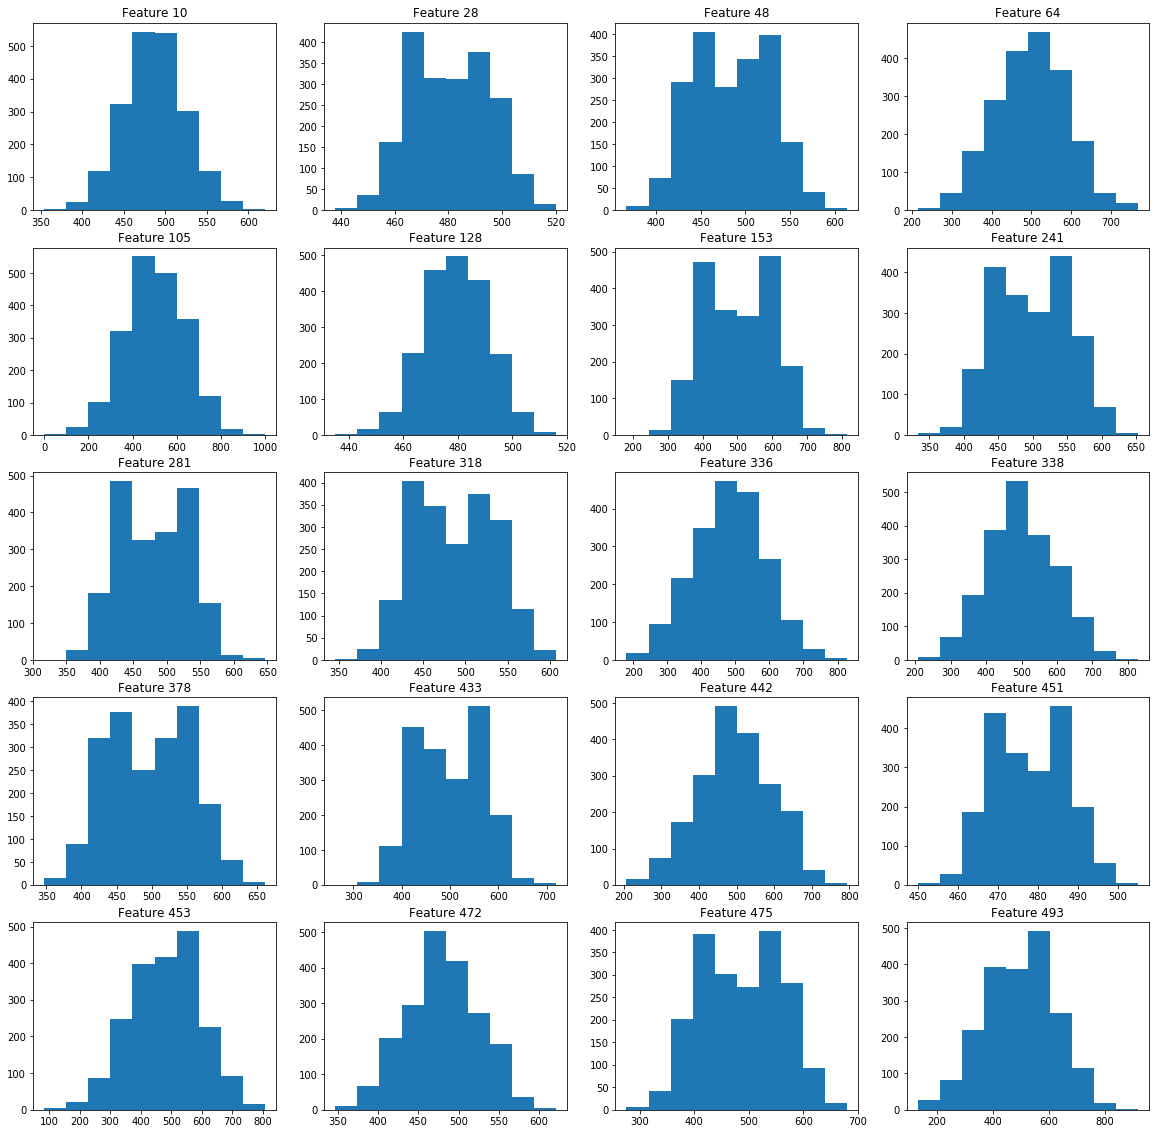

In [7]:
fig = plt.figure(figsize=(20, 20))

for i in range(len(x_sel.columns)):
    fig.add_subplot(5, 4, i + 1)
    plt.hist(x_sel.iloc[:, i])
    plt.title(f"Feature {x_sel.columns[i]}")

# Logistic Regression

In [13]:
logregPipe = Pipeline([('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(random_state=123))])
_ = logregPipe.fit(x_train, y_train)

In [360]:
print('accuracy on the tain set: ', logregPipe.score(x_train, y_train))
print('accuracy on the test set: ', logregPipe.score(x_test, y_test))

accuracy on the tain set:  0.6326666666666667
accuracy on the test set:  0.572


           selected parameter
logreg__C            0.151991


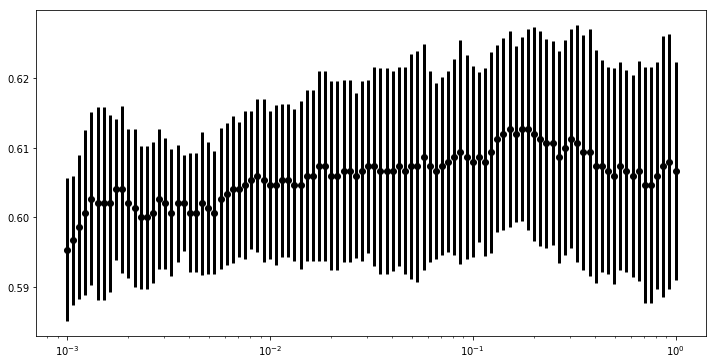

In [361]:
param_space = np.logspace(-3, 0, 100)
logregParam = {'logreg__C': param_space}
logregGS = GridSearchCV(estimator=logregPipe, param_grid=logregParam, cv=5)
logregGS.fit(x_train, y_train)
print(pd.DataFrame.from_dict(logregGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = logregGS.cv_results_["mean_test_score"]
std_test_score = logregGS.cv_results_["std_test_score"]
plt.figure(figsize=(12, 6))
plt.errorbar(param_space, mean_test_score, std_test_score, fmt='ok', lw=3)
plt.xscale('log')
logregGS.estimator.steps[1][1].C = logregGS.best_params_["logreg__C"]

In [362]:
print("accuracy on the test set: ",
      accuracy_score(y_test, logregGS.predict(x_test)))
print("accuracy on the train set: ",
      accuracy_score(y_train, logregGS.predict(x_train)))

accuracy on the test set:  0.598
accuracy on the train set:  0.628


In [363]:
knnGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, knnGS_ypreds), columns=['Predicted -1', 'Predicted 1'],\
                                index=['Actual -1', 'Actual 1'])
knnGS_confMatrix

,Predicted -1,Predicted 1
Actual -1,115,123
Actual 1,134,128


# KNeighborsClassifier

In [364]:
knnPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs=-1)),
])
knnParam = {
    'knn__n_neighbors': [1, 3, 5, 7, 8, 9, 10, 11],
    'knn__weights': ['uniform', 'distance'],
}
_ = knnPipe.fit(x_train, y_train)

In [365]:
print('accuracy on the train set: ', knnPipe.score(x_train, y_train))
print('accuracy on the test set: ', knnPipe.score(x_test, y_test))

accuracy on the train set:  0.9173333333333333
accuracy on the test set:  0.878


                 selected parameter
knn__n_neighbors                  3
knn__weights                uniform


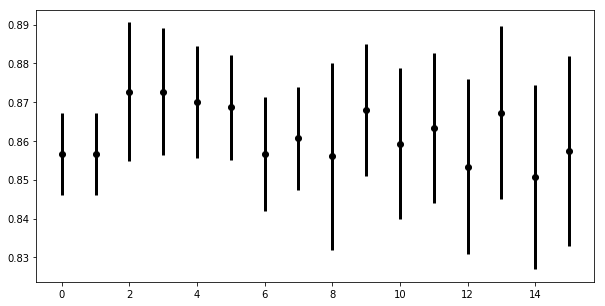

In [366]:
knnGS = GridSearchCV(knnPipe, param_grid=knnParam, n_jobs=-1)
_ = knnGS.fit(x_train, y_train)
print(pd.DataFrame.from_dict(knnGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = knnGS.cv_results_["mean_test_score"]
std_test_score = knnGS.cv_results_["std_test_score"]
plt.figure(figsize=(10, 5))
_ = plt.errorbar(np.arange(mean_test_score.shape[0]),
                 mean_test_score,
                 std_test_score,
                 fmt='ok',
                 lw=3)

In [367]:
print("accuracy on the train set: ", knnGS.score(x_train, y_train))
print("accuracy on the test set:", knnGS.score(x_test, y_test))

accuracy on the train set:  0.9406666666666667
accuracy on the test set: 0.88


In [368]:
knnGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, knnGS.predict(x_test)), \
                                columns=['Predicted -1', 'Predicted 1'], \
                                index=['Actual -1', 'Actual 1'])
knnGS_confMatrix

,Predicted -1,Predicted 1
Actual -1,211,27
Actual 1,33,229


# DecisionTree Classifier

In [369]:
dectreePipe = Pipeline([('scaler', StandardScaler()),
                        ('dectree', DecisionTreeClassifier(random_state=123))])
dectreeParam = {
    'dectree__criterion': ['gini', 'entropy'],
    'dectree__class_weight': ['balanced', None]
}
_ = dectreePipe.fit(x_train, y_train)

In [370]:
print('accuracy on the train set: ', dectreePipe.score(x_train, y_train))
print('accuracy on the test set: ', dectreePipe.score(x_test, y_test))

accuracy on the train set:  1.0
accuracy on the test set:  0.79


                      selected parameter
dectree__class_weight               None
dectree__criterion                  gini


<ErrorbarContainer object of 3 artists>

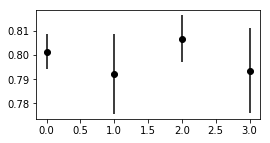

In [371]:
dectreeGS = GridSearchCV(dectreePipe, param_grid=dectreeParam, cv=5)
_ = dectreeGS.fit(x_train, y_train)
print(pd.DataFrame.from_dict(dectreeGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = dectreeGS.cv_results_["mean_test_score"]
std_test_score = dectreeGS.cv_results_["std_test_score"]
plt.figure(figsize=(4, 2))
plt.errorbar(np.arange(mean_test_score.shape[0]),
             mean_test_score,
             std_test_score,
             fmt='ok')

In [372]:
print('accuracy on the train set: ', dectreeGS.score(x_train, y_train))
print('accuracy on the test set: ', dectreeGS.score(x_test, y_test))

accuracy on the train set:  1.0
accuracy on the test set:  0.79


In [373]:
pd.DataFrame(confusion_matrix(y_test, dectreeGS_ypreds),
             columns=['Predicted -1', 'Predicted 1'],
             index=['Actual -1', 'Actual 1'])

,Predicted -1,Predicted 1
Actual -1,108,130
Actual 1,125,137


# Random Forest

In [374]:
from sklearn.ensemble import RandomForestClassifier

randtreePipe = Pipeline([('scaler', StandardScaler()),
                         ('randtree',
                          RandomForestClassifier(random_state=123,
                                                 n_estimators=100,
                                                 bootstrap=False))])
max_depth_param = range(5, 25)
randtreeParam = {'randtree__max_depth': max_depth_param}
_ = randtreePipe.fit(x_train, y_train)

In [375]:
print('accuracy on the train set: ', randtreePipe.score(x_train, y_train))
print('accuracy on the test set: ', randtreePipe.score(x_test, y_test))

accuracy on the train set:  1.0
accuracy on the test set:  0.896


                     selected parameter
randtree__max_depth                  14


<ErrorbarContainer object of 3 artists>

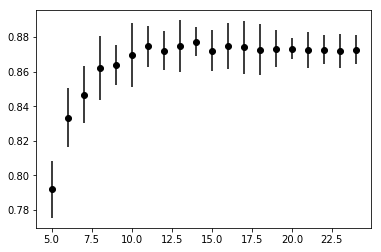

In [376]:
randtreeGS = GridSearchCV(randtreePipe, param_grid=randtreeParam, cv=5)
randtreeGS.fit(x_train, y_train)
mean_test_score = randtreeGS.cv_results_["mean_test_score"]

std_test_score = randtreeGS.cv_results_["std_test_score"]

print(
    pd.DataFrame.from_dict(randtreeGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))

pd.DataFrame(randtreeGS.cv_results_).sort_values(by='rank_test_score')[:5][[
    'rank_test_score', 'param_randtree__max_depth', 'mean_test_score',
    'std_test_score'
]].T

plt.figure(figsize=(6, 4))
plt.errorbar(max_depth_param, mean_test_score, std_test_score, fmt='ok')

In [377]:
print("accuracy on the train set", randtreeGS.score(x_train, y_train))
print("accuracy on the test set", randtreeGS.score(x_test, y_test))

accuracy on the train set 1.0
accuracy on the test set 0.89


In [378]:
randtreeGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, randtreeGS_ypreds), columns=['Predicted -1', \
                                                                                               'Predicted 1'],\
                                   index=['Actual -1', 'Actual 1'])
randtreeGS_confMatrix

,Predicted -1,Predicted 1
Actual -1,117,121
Actual 1,129,133


# Porównanie Dokładności Modeli

In [379]:
print("Logistic Regression")
print("accuracy on the train set: ", logregGS.score(x_train, y_train))
print("accuracy on the test set: ", logregGS.score(x_test, y_test))

print("\nK-Neighbors Classifier")
print("accuracy on the train set: ", knnGS.score(x_train, y_train))
print("accuracy on the test set:", knnGS.score(x_test, y_test))

print("\nDecision Tree Classifier")
print('accuracy on the train set: ', dectreeGS.score(x_train, y_train))
print('accuracy on the test set: ', dectreeGS.score(x_test, y_test))

print("\nRandomForestClassifier")
print("accuracy on the train set", randtreeGS.score(x_train, y_train))
print("accuracy on the test set", randtreeGS.score(x_test, y_test))

Logistic Regression
accuracy on the train set:  0.628
accuracy on the test set:  0.598

K-Neighbors Classifier
accuracy on the train set:  0.9406666666666667
accuracy on the test set: 0.88

Decision Tree Classifier
accuracy on the train set:  1.0
accuracy on the test set:  0.79

RandomForestClassifier
accuracy on the train set 1.0
accuracy on the test set 0.89


# Wybierzmy najlepszy model przy zastosowaniu różnych cech

In [7]:
print("Logistic Regression")
for features_name, features in {'features_KNR': features_KNR, 'features_DTR': features_DTR, 'features_boruta': features_boruta,}.items():
    print("\t",features_name,len(features))
    x_sel = x_df.iloc[:, features]
    x_val_sel = x_df_val.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)
    
    param_space = np.logspace(-3, 0, 100)
    logregParam = {'logreg__C': param_space}
    logregPipe = Pipeline([('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(random_state=123))])
    logregGS = GridSearchCV(estimator=logregPipe, param_grid=logregParam, cv=5)
    logregGS.fit(x_train, y_train)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)
    
    cv_train = cross_val_score(logregGS, x_train, y_train, cv=skf,scoring="accuracy")
    cv_test = cross_val_score(logregGS, x_test, y_test, cv=skf,scoring="accuracy")
    
    print("\t\tCV accuracy on the train set: ", cv_train.mean().round(3)*100, "%")
    print("\t\tCV accuracy on the test set:", cv_test.mean().round(3)*100, "%")
    
#     print("\t\taccuracy on the train set: ", logregGS.score(x_train, y_train).round(3))
#     print("\t\taccuracy on the test set:", logregGS.score(x_test, y_test).round(3))    

Logistic Regression
	 features_KNR 19
		CV accuracy on the train set:  58.3 %
		CV accuracy on the test set: 62.8 %
	 features_DTR 16
		CV accuracy on the train set:  60.3 %
		CV accuracy on the test set: 62.6 %
	 features_boruta 20
		CV accuracy on the train set:  59.199999999999996 %
		CV accuracy on the test set: 61.6 %


In [8]:
print("\nK-Neighbors Classifier")
for features_name, features in {'features_KNR': features_KNR, 'features_DTR': features_DTR, 'features_boruta': features_boruta,}.items():
    print("\t",features_name,len(features))
    x_sel = x_df.iloc[:, features]
    x_val_sel = x_df_val.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)
    knnPipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_jobs=-1)),
    ])
    knnParam = {
        'knn__n_neighbors': [1, 3, 5, 7, 8, 9, 10, 11],
        'knn__weights': ['uniform', 'distance'],
    }
    knnGS = GridSearchCV(knnPipe, param_grid=knnParam, n_jobs=-1)
    _ = knnGS.fit(x_train, y_train)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)
    
    cv_train = cross_val_score(knnGS, x_train, y_train, cv=skf,scoring="accuracy")
    cv_test = cross_val_score(knnGS, x_test, y_test, cv=skf,scoring="accuracy")
    
    print("\t\tCV accuracy on the train set: ", (cv_train.mean()*100).round(3), "%")
    print("\t\tCV accuracy on the test set:", (cv_test.mean()*100).round(3), "%")
    
#     print("\t\taccuracy on the train set: ", knnGS.score(x_train, y_train))
#     print("\t\taccuracy on the test set:", knnGS.score(x_test, y_test))


K-Neighbors Classifier
	 features_KNR 19
		CV accuracy on the train set:  82.936 %
		CV accuracy on the test set: 72.78 %
	 features_DTR 16
		CV accuracy on the train set:  88.866 %
		CV accuracy on the test set: 82.229 %
	 features_boruta 20
		CV accuracy on the train set:  87.2 %
		CV accuracy on the test set: 81.413 %


In [31]:
print("\nDecision Tree Clasifier")
for features_name, features in {'features_KNR': features_KNR, 'features_DTR': features_DTR, 'features_boruta': features_boruta,}.items():
    print("\t",features_name,len(features))
    x_sel = x_df.iloc[:, features]
    x_val_sel = x_df_val.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)
    
    dectreePipe = Pipeline([('scaler', StandardScaler()),
                        ('dectree', DecisionTreeClassifier(random_state=123))])
    dectreeParam = {
        'dectree__criterion': ['gini', 'entropy'],
        'dectree__class_weight': ['balanced', None]
    }
    dectreeGS = GridSearchCV(dectreePipe, param_grid=dectreeParam, cv=5)
    _ = dectreeGS.fit(x_train, y_train)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)
    
    cv_train = cross_val_score(dectreeGS, x_train, y_train, cv=skf,scoring="accuracy")
    cv_test = cross_val_score(dectreeGS, x_test, y_test, cv=skf,scoring="accuracy")
    
    print("\t\tCV accuracy on the train set: ", (cv_train.mean()*100).round(3), "%")
    print("\t\tCV accuracy on the test set:", (cv_test.mean()*100).round(3), "%")
    
#     print("\t\taccuracy on the train set: ", dectreeGS.score(x_train, y_train))
#     print("\t\taccuracy on the test set:", dectreeGS.score(x_test, y_test))


Decision Tree Clasifier
	 features_KNR 21
		CV accuracy on the train set:  67.732 %
		CV accuracy on the test set: 63.611 %
	 features_DTR 18
		CV accuracy on the train set:  80.2 %
		CV accuracy on the test set: 71.395 %
	 features_boruta 20
		CV accuracy on the train set:  78.866 %
		CV accuracy on the test set: 70.993 %


In [ ]:
print("\nRandom Forest Classifier")
for features_name, features in {'features_KNR': features_KNR, 'features_DTR': features_DTR, 'features_boruta': features_boruta,}.items():
    print("\t",features_name,len(features))
    x_sel = x_df.iloc[:, features]
    x_val_sel = x_df_val.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)
    
    randtreePipe = Pipeline([('scaler', StandardScaler()),
                         ('randtree',
                          RandomForestClassifier(random_state=123,
                                                 n_estimators=100,
                                                 bootstrap=True))])
    max_depth_param = range(5, 25)
    randtreeParam = {'randtree__max_depth': max_depth_param}
    randtreeGS = GridSearchCV(randtreePipe, param_grid=randtreeParam, cv=5)
    randtreeGS.fit(x_train, y_train)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)
    
    cv_train = cross_val_score(randtreeGS, x_train, y_train, cv=skf,scoring="accuracy")
    cv_test = cross_val_score(randtreeGS, x_test, y_test, cv=skf,scoring="accuracy")
    
    print("\t\tCV accuracy on the train set: ", (cv_train.mean()*100).round(3), "%")
    print("\t\tCV accuracy on the test set:", (cv_test.mean()*100).round(3), "%")
    
#     print("\t\taccuracy on the train set: ", randtreeGS.score(x_train, y_train))
#     print("\t\taccuracy on the test set:", randtreeGS.score(x_test, y_test))


Random Forest Classifier
	 features_KNR 19
		CV accuracy on the train set:  84.6 %
		CV accuracy on the test set: 76.4 %
	 features_DTR 16


In [ ]:
# save_data = knnGS.predict_proba(x_val_sel)[:, 1]
# np.savetxt("foo.csv", save_data, delimiter="", fmt='%f', header="\r\"MATDOR\"")

# Wnioski

Najlepsze cechy (20 kolumn) wybrał algorytm Boruta

Najlepszym modelem okazał się: K-Neighbors Classifier